<a href="https://colab.research.google.com/github/seandavi/notebooks/blob/main/mnist_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/seandavi/notebooks/HEAD?labpath=mnist_pytorch.ipynb)

# The MNIST dataset

The MNIST (Modified National Institute of Standards and Technology) dataset is a widely-used benchmark for evaluating the performance of machine learning models on handwritten digit recognition. The dataset consists of 70,000 grayscale images of handwritten digits (0 through 9), where each image is 28 pixels by 28 pixels in size.

The MNIST dataset is split into a training set of 60,000 examples and a test set of 10,000 examples. The training set is used to train the machine learning model, while the test set is used to evaluate the model's performance on unseen data.

The dataset has several key characteristics that make it a valuable resource for learning and experimentation:

1. **Standardized Format**: The images in the MNIST dataset are all pre-processed and centered, making them well-suited for training and evaluating image classification models.

2. **Practical Relevance**: Handwritten digit recognition is a common real-world application of machine learning, with uses in areas like postal code reading, bank check processing, and form data entry.

3. **Moderate Complexity**: The MNIST dataset is complex enough to be a meaningful benchmark, yet not overly complicated, making it an excellent starting point for beginners in machine learning and computer vision.

4. **Extensive Use**: The MNIST dataset has been used extensively in the machine learning community, with a wealth of published research and reference implementations available. This allows learners to compare their models and results against established baselines.

By working with the MNIST dataset in this exercise, you will have the opportunity to build, train, and evaluate a neural network model for handwritten digit classification. This hands-on experience will provide a solid foundation for understanding the key concepts and techniques involved in image recognition tasks using deep learning.

# Introduction to Python and Jupyter Notebooks

Welcome to this tutorial on using Python and machine learning to classify the MNIST handwritten digit dataset. In this notebook, we'll cover the basics of Python programming and the Jupyter Notebook environment, as well as how to install packages and import libraries.

## What is Python?
Python is a high-level, general-purpose programming language that is widely used for a variety of applications, including web development, data analysis, machine learning, and scientific computing. Python is known for its simplicity, readability, and ease of use, making it a great language for beginners to learn.

## What is a Jupyter Notebook?
A Jupyter Notebook is an open-source web application that allows you to create and share documents that contain live code, visualizations, and narrative text. Jupyter Notebooks are often used for data exploration, analysis, and presentation. They provide an interactive coding environment where you can write, execute, and document your code all in one place.

## How to use this notebook
The idea is that you can step through this notebook without having to write your own code. You can do so by typing "Shift + Enter" at the same time. If there is code in the "cell" that code will run and will output right below the cell. If there is just "text" in the cell, then you'll just jump to the next cell. In practice, just keep hitting "Shift + Enter."

## Installing Packages
In Python, you can extend the functionality of the language by installing packages, which are collections of modules, functions, and data that provide specific capabilities. You can install packages using a package manager like `pip`, the Python Package Installer.

For example, to install the `numpy` package, which provides support for large, multi-dimensional arrays and matrices, you would run the following command in your terminal or command prompt:

```
pip install numpy
```




In [33]:
! pip install -q torch torchvision scikit-learn matplotlib seaborn seaborn_image

In [ ]:
# Create output folder
import pathlib
pathlib.Path("mnist_pytorch_output").mkdir(parents=True, exist_ok=True)


## Importing Libraries
In addition to installing packages, you can also import Python libraries directly into your Jupyter Notebook. Libraries are collections of pre-written code that provide specific functionality, such as data manipulation, visualization, or machine learning.

For example, to use the `pandas` library for data manipulation, you would write:

```python
import pandas as pd
```

This allows you to use the `pd` prefix to access the functions and features of the `pandas` library.

In the next code block, we import the libraries that we will be needing in
this notebook.


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

This import block above sets up the core PyTorch libraries and utilities we'll need to build and train a neural network model to classify handwritten digits from the MNIST dataset.

Let's walk through the packages and what the code above is doing.

```python
import torch
import torch.nn as nn
import torch.optim as optim
```

These lines import the core [PyTorch] library, which is a popular open-source machine learning framework. `torch` provides the fundamental data structures, mathematical operations, and hardware acceleration needed for building and training neural networks.

[PyTorch]: https://pytorch.org/

`torch.nn` contains the building blocks for creating neural network layers and models.
`torch.optim` provides optimization algorithms, like gradient descent, that are used to train neural networks.

```python
from torchvision import datasets, transforms
```

`torchvision` is a [PyTorch] library that provides pre-built datasets and data transformation functions. Here, we're specifically importing the `datasets` and `transforms` modules.

`datasets` contains commonly used machine learning datasets, like MNIST, CIFAR10, and ImageNet.
`transforms` provides functions to preprocess and augment data, such as resizing, cropping, and normalizing images.

```python
from torch.utils.data import DataLoader
```

`DataLoader` is a [PyTorch] utility that makes it easy to load and iterate over datasets in batches during training and evaluation.

```python
import matplotlib.pyplot as plt
```

Finally, we import the `matplotlib.pyplot` library, which is a widely used data visualization library in Python. We'll use this to plot images and charts related to our machine learning model.


In [ ]:
class MultiNeuron(nn.Module):
    def __init__(self):
        super(MultiNeuron, self).__init__()
        # Multi neuron: 784 inputs (28x28 pixels) -> 10 outputs (one for each digit)
        self.neuron = nn.Linear(784, 10)

    def forward(self, x):
        # Flatten the 28x28 image to 784 pixels
        x = x.view(-1, 784)
        # Apply the linear transformation
        return self.neuron(x)  # No activation function here

```python
class MultiNeuron(nn.Module):
```
This defines a new PyTorch model class called `MultiNeuron` that inherits from the base `nn.Module` class. `nn.Module` is the base class for all neural network models in PyTorch, and it provides the necessary functionality for building, training, and evaluating models.

```python
    def __init__(self):
        super(MultiNeuron, self).__init__()
        # Multi neuron: 784 inputs (28x28 pixels) -> 10 outputs (one for each digit)
        self.neuron = nn.Linear(784, 10)
```
The `__init__` method is a special method in Python classes that is used to create a new object and initialize the object's attributes. Here, we're calling the `__init__` method of the parent `nn.Module` class using `super().__init__()`, and then creating a new `nn.Linear` layer as an attribute of the `MultiNeuron` class.

The key aspects of this model are:

1. **Input Size:** The input to the model is a flattened 28x28 pixel image, resulting in 784 input features.
2. **Output Size:** The model has 10 output features, corresponding to the 10 possible digit classes (0 through 9).
3. **Neural Network Layer:** The model contains a single `nn.Linear` layer, which performs a linear transformation, mapping the 784 input features (the flattened 28x28 pixel image) to the 10 output features.


```python
    def forward(self, x):
        # Flatten the 28x28 image to 784 pixels
        x = x.view(-1, 784)
        # Apply the linear transformation
        return self.neuron(x)
```
The `forward` method defines the forward pass of the neural network. This is where the actual computation happens when the model is used for inference or training.

1. First, we flatten the input 2D image (with dimensions 28x28) into a 1D vector of 784 pixels using the `view` method.
2. We then pass this flattened input through the `self.neuron` linear layer, which performs the linear transformation.

The `forward` method defines the data flow through the neural network, and PyTorch will automatically compute the gradients for this function during the backpropagation phase of training.

## Model components

In PyTorch and neural networks, the fundamental building blocks of neural networks are **layers**. Layers are responsible for transforming the input data into a desired output. Examples of common layers include:

1. **Linear (Fully Connected) Layer**: Performs a linear transformation on the input, mapping it to a new set of features.
2. **Convolutional Layer**: Applies a set of learnable filters to the input, useful for processing spatial data like images.
3. **Pooling Layer**: Reduces the spatial size of the input, typically used to reduce the number of parameters and computational complexity.
4. **Activation Layer**: Applies a non-linear activation function to the input, such as ReLU, sigmoid, or tanh.

These layers can be stacked together to create **models**, which represent the complete neural network architecture. In PyTorch, models are defined by subclassing the `nn.Module` class, which provides the necessary functionality for building, training, and evaluating neural networks.

When defining a model in PyTorch, you typically:

1. **Initialize the Layers**: Create instances of the desired layer types and store them as attributes of the `nn.Module` subclass.
2. **Define the Forward Pass**: Implement the `forward()` method, which describes how the input data flows through the various layers of the model.

This modular approach allows you to easily experiment with different layer types, depths, and configurations to find the optimal architecture for your specific machine learning task.

PyTorch also provides a rich ecosystem of pre-built models, such as VGG, ResNet, and BERT, which you can use as a starting point for your own projects. These pre-trained models can be fine-tuned on your specific dataset, often leading to better performance compared to training a model from scratch.

The model we have here is small and simple, but PyTorch allows creating very complex models by simply adding layers.

## An unknown model

In many cases, you would be using an "off-the-shelf" model. In this case, you can use the `model.eval` method to show you the neural network. In this case, `model.eval` shows us the model we just created.

In [36]:
model = MultiNeuron()

model.eval()

MultiNeuron(
  (neuron): Linear(in_features=784, out_features=10, bias=True)
)

# Loading data

The next few lines of code are responsible for loading and setting up the data (the `transform`) for machine learning.

In [37]:
# Define the transformation for the dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])


Next, we load the training and testing datasets. Note that they are separated. In some cases, you may need to separate them yourself.

In [38]:
# Load the MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform)

This line loads the MNIST dataset. The root='./data' argument specifies the directory where the dataset will be downloaded and stored. The train=True argument indicates that we are loading the training set (as opposed to the test set). The download=True argument tells PyTorch to download the dataset if it's not already available. Finally, the transform=transform argument applies the data transformations we defined earlier.

In [39]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

This line creates a DataLoader object, which is responsible for feeding the data to the model during training and evaluation. The dataset=train_dataset argument specifies the dataset to use. The batch_size=64 argument sets the number of samples to include in each batch. The shuffle=True argument tells the DataLoader to shuffle the data samples before each epoch, which can help the model generalize better.



In [40]:
# Initialize the model, loss function, and optimizer
model = MultiNeuron()

# Loss and optimization

Remember that when we are training a neural network, we need some measure of how "right" or "wrong" we are. We often talk about a "loss function" that we want to minimize, resulting in a minimal error. We minimize that loss function by using an "optimizer." We'll show those concepts and code next.

## Loss function

The loss function is the measure of the current error in our model.

In [41]:
criterion = nn.CrossEntropyLoss()

This line of code above defines the loss function that will be used to train the neural network model. In the context of a multi-class classification problem like MNIST, the appropriate loss function to use is the **Cross Entropy Loss**.

The **Cross Entropy Loss** is a popular loss function for multi-class classification tasks. It measures the difference between the model's predicted probability distribution over the classes and the true distribution (given by the target class labels). The goal during training is to minimize this loss, which will encourage the model to make accurate predictions.

By using `nn.CrossEntropyLoss()`, we're leveraging the implementation of the cross entropy loss function provided by the PyTorch `nn` (neural network) module. This loss function takes the model's raw, unnormalized outputs (the "logits") and the true class labels, and computes the cross entropy loss.

## Optimizer

In the context of training a neural network, an **optimizer** is an algorithm that adjusts the model's parameters (e.g., the weights and biases of the layers) in order to minimize the loss function. The optimizer does this by computing the gradients of the loss with respect to the model parameters and then updating the parameters accordingly.

One of the most popular optimizers used in deep learning is **Stochastic Gradient Descent (SGD)**. SGD is an iterative optimization algorithm that updates the model parameters in the direction opposite to the gradient of the loss function.

In PyTorch, the `torch.optim` module provides a variety of optimization algorithms, including SGD. Let's see how we can use a specific optimizer in our code:

In [42]:
optimizer = optim.SGD(model.parameters(), lr=0.01)

In this example, we're creating an SGD optimizer using `optim.SGD()`. The `model.parameters()` argument tells the optimizer which parameters it should update (in this case, all the parameters of the `MultiNeuron` model). The `lr=0.01` argument sets the **learning rate**, which is a hyperparameter that controls the step size of the gradient updates [don't worry about these details].

During the training loop, the optimizer will be used to update the model's parameters after each batch of data. Specifically, the steps are:

1. Compute the loss between the model's predictions and the true labels.
2. Compute the gradients of the loss with respect to the model parameters.
3. Use the optimizer to update the model parameters in the direction opposite to the gradients, with the learning rate controlling the step size.

This iterative process of computing the loss, gradients, and updating the parameters is what allows the model to learn and improve its performance over time.

# Training

Training a machine learning model is an iterative process of improving the model's performance on a given task. In the case of the MNIST digit classification problem, our goal is to train a neural network model that can accurately predict the digit represented in an input image.

The training process involves feeding the model batches of training data, consisting of images and their corresponding digit labels. The model generates predictions for each input image, and we compute a loss function that measures how different the model's predictions are from the true labels. We then use an optimization algorithm to update the model's parameters (the weights and biases of the neural network layers) in a way that minimizes this loss function.

By repeating this process of forward inference, loss computation, and parameter updates over many iterations (called **"epochs"**), the model learns to recognize the patterns in the training data and improve its ability to classify new, unseen images correctly. The goal is to train the model to the point where it achieves high accuracy on both the training data and a separate test dataset, indicating that it has learned to generalize well and can be deployed to make accurate predictions on real-world data.

With this high-level understanding of the training process and objectives, let's dive into the specific code that implements the training loop for the MNIST digit classification task.

In [ ]:
# Training loop
# This will take a while, so read ahead
num_epochs = 3
for epoch in range(num_epochs):
    for images, labels in train_loader:
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/3], Loss: 0.4183


What is going on in this code?

```python
num_epochs = 3
for epoch in range(num_epochs):
```

This sets the number of training epochs, which is the number of times the entire training dataset will be passed through the model. In this case, we're training for 3 epochs.

The outer loop iterates over the epochs, allowing us to train the model for the specified number of passes through the data.

```python
    for images, labels in train_loader:
```

This inner loop iterates over the training data, fetching batches of images and their corresponding labels from the `train_loader` DataLoader. Recall that the DataLoader was responsible for managing the dataset, including shuffling and batching the data.

The **training process** typically involves the following steps:

1. **Forward Pass**: The model takes a batch of input images and produces output predictions.
2. **Loss Computation**: The model's predictions are compared to the true labels using the specified loss function (in this case, `nn.CrossEntropyLoss()`). This computes the **loss**, which is a measure of how well the model is performing on the current batch of data.
3. **Backpropagation**: The gradients of the loss with respect to the model's parameters are computed using the **backpropagation** algorithm. Backpropagation is the process of efficiently computing the gradients by propagating the error signal backwards through the layers of the neural network.
4. **Optimization**: The **optimizer** (in this case, `optim.SGD()`) uses the computed gradients to update the model's parameters in the direction that will minimize the loss. This is done using an optimization algorithm like Stochastic Gradient Descent (SGD).

Let's look at the code that implements these steps:

```python
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
```

1. **Forward Pass**: The `model(images)` line performs the forward pass, where the `MultiNeuron` model takes the input `images` and produces the `outputs`, which are the raw, unnormalized logits for each class.
2. **Loss Computation**: The `criterion(outputs, labels)` line computes the cross-entropy loss between the model's predictions (`outputs`) and the true labels (`labels`).
3. **Backpropagation**: The `loss.backward()` line performs the backpropagation step, computing the gradients of the loss with respect to the model's parameters.
4. **Optimization**: The `optimizer.zero_grad()` line clears any existing gradients in the optimizer, and the `optimizer.step()` line updates the model's parameters using the computed gradients and the optimization algorithm (in this case, SGD).

Finally, after each epoch, the code prints the current epoch number and the average loss for that epoch:

```python
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
```

This provides a way to monitor the training progress and observe how the model's performance improves over the course of the training.

In summary, this training loop iterates over the batches of data, performs the forward pass, computes the loss, backpropagates the gradients, and uses the optimizer to update the model's parameters. This process is repeated for the specified number of epochs, allowing the model to learn and improve its performance on the MNIST dataset.

# Model evaluation

After training a machine learning model, we typically want to evaluate its performance to ensure it is meeting the desired objectives. In the context of the MNIST digit classification task, evaluating the model's accuracy is a key step in determining how well it has learned to recognize the handwritten digits.

The typical approach is to split the available dataset into two parts: a training set and a separate test set. The model is trained using the training data, as we've seen in the previous code snippet. However, the true measure of the model's performance is _how well it generalizes to new, unseen data_. This is where the test set comes into play. By evaluating the model's predictions on the test set, we can get an unbiased estimate of its accuracy on data it has not been trained on.

There are a few key metrics that are commonly used to evaluate the model's performance on the test set. The most straightforward is the **classification accuracy** (which we will evaluate below), which represents the percentage of test samples that the model correctly classifies. Other metrics, such as precision, recall, and F1-score, can provide additional insights into the model's strengths and weaknesses. Carefully analyzing these evaluation metrics will help us understand how well the model has learned to generalize and identify any areas for further improvement.

By rigorously evaluating the model's performance, we can gain confidence in its ability to make accurate predictions on real-world data, and make informed decisions about deploying the model in production environments. This evaluation process is a crucial step in the machine learning workflow and should not be overlooked.

In [ ]:

# Function to calculate accuracy
def calculate_accuracy(loader, model):
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy


This `calculate_accuracy` function takes a data loader (either the `train_loader` or the `test_loader`) and the trained model as input. It then iterates through the samples in the data loader, passes the images through the model to get the predictions, and compares the predicted labels to the true labels. The function keeps track of the total number of samples and the number of correct predictions, and then calculates and returns the overall accuracy as a percentage.

The key aspects to note are:

1. The `with torch.no_grad():` context manager is used to disable gradient computations during the accuracy calculation. This is because we're only interested in the model's predictions, not in updating the model's parameters.
2. The `torch.max(outputs.data, 1)` line finds the index of the maximum value in the model's output logits, which corresponds to the predicted class label.
3. The `(predicted == labels).sum().item()` line counts the number of correctly predicted samples by comparing the predicted labels to the true labels.

Now, let's look at how we use this `calculate_accuracy` function to evaluate the model's performance:


In [ ]:
# Calculate accuracy on the training set
train_accuracy = calculate_accuracy(train_loader, model)
print(f'Training Accuracy: {train_accuracy:.2f}%')

In [ ]:
# And now, on the testing set
test_accuracy = calculate_accuracy(test_loader, model)
print(f'Test Accuracy: {test_accuracy:.2f}%')

By calculating the accuracy on both the training data and the test data, we can gain valuable insights into the model's performance and behavior:

1. **Training Accuracy**: The training accuracy represents how well the model is able to fit the training data. If the training accuracy is very high (e.g., close to 100%), it suggests that the model has learned to memorize the training samples, rather than generalize to new data. This is a sign of **overfitting**, where the model has "memorized" the training data but fails to perform well on unseen test data.

2. **Test Accuracy**: The test accuracy represents how well the model generalizes to new, unseen data. This is the true measure of the model's performance and the key indicator of how well it will perform in real-world scenarios. If the test accuracy is significantly lower than the training accuracy, it suggests that the model is overfitting and has not learned to generalize effectively.

By comparing the training and test accuracies, we can get a sense of the model's **fit** to the data. Ideally, we want the training and test accuracies to be close to each other, indicating that the model has learned meaningful patterns in the data and can apply them to new samples. A large drop from the training and test accuracy is a sign of overfitting, meaning that our model is not generalizing well from our training data to our test data, indicating the need to modify the model architecture, adjust the training hyperparameters, or incorporate additional techniques to improve the model's generalization capabilities.

Monitoring the evolution of the training and test accuracies during the training process can also provide valuable insights into the model's learning dynamics and help guide the optimization of the model's performance.

# Model introspection

Visualizing the weights of a neural network model can provide valuable insights into what the model has learned and how it is making its predictions. In the case of the MNIST digit classification task, examining the weights of the output layer can give us a deeper understanding of the model's internal representations.

The output layer of the `MultiNeuron` model consists of 10 neurons, each corresponding to one of the 10 digit classes (0 through 9). The weights of each output neuron can be interpreted as a template or pattern that the model has learned to associate with a particular digit. By visualizing these weight patterns, we can gain intuition about the model's decision-making process.

For example, if we were to visualize the weights of the output neuron corresponding to the digit "3", we might see a pattern that resembles the strokes and shapes typically found in handwritten 3s. Similarly, the weight patterns for the other digits would likely reflect the distinctive visual characteristics of those digits. Analyzing these weight visualizations can help us understand which features the model has learned to focus on when classifying the input images. This can be particularly useful for identifying the model's strengths, weaknesses, and potential biases, which can inform further refinements or modifications to the model architecture or training process.

By inspecting the learned weight patterns, we can develop a more nuanced understanding of how the neural network model is processing the input data and making its predictions. This type of interpretability can be invaluable for building trust in the model's capabilities, as well as identifying opportunities for improving its performance and robustness.

The code below is "complex" but the final result is a visualization of the weights for each of the 10 output neurons. The colors represent the actual weights for each pixel.

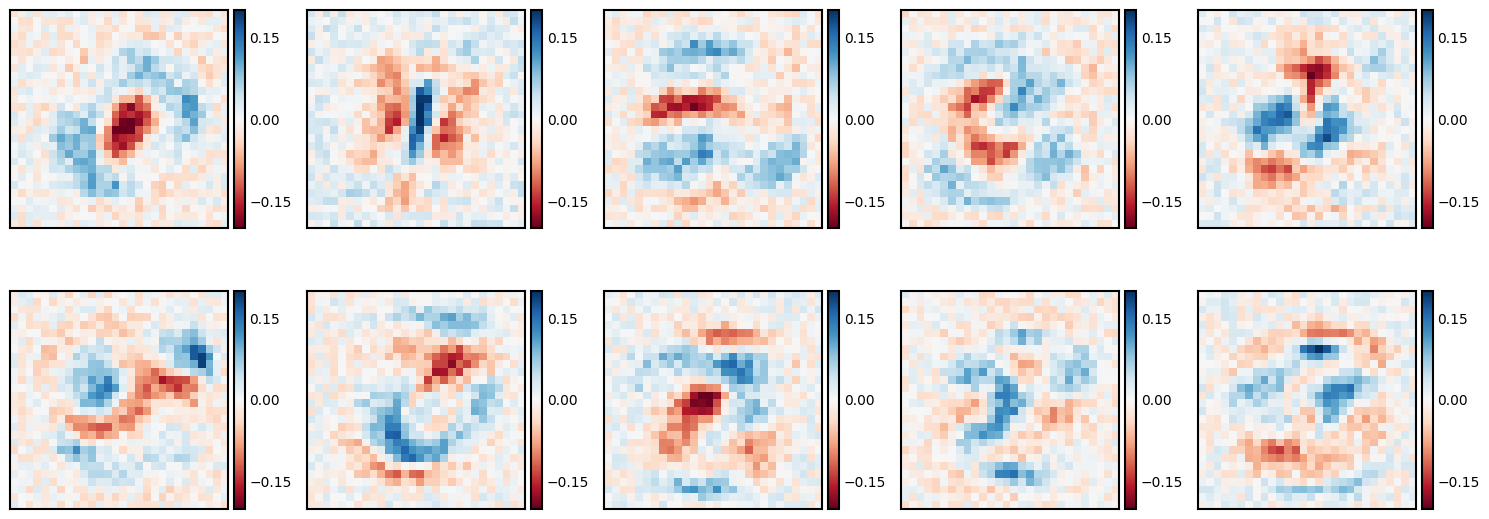

In [ ]:
import seaborn_image as isns
isns.ImageGrid(model.neuron.weight.data.cpu().numpy().reshape(10,28,28), cmap='RdBu', col_wrap=5, axis=0, vmin=-0.2, vmax=0.2)